In [53]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


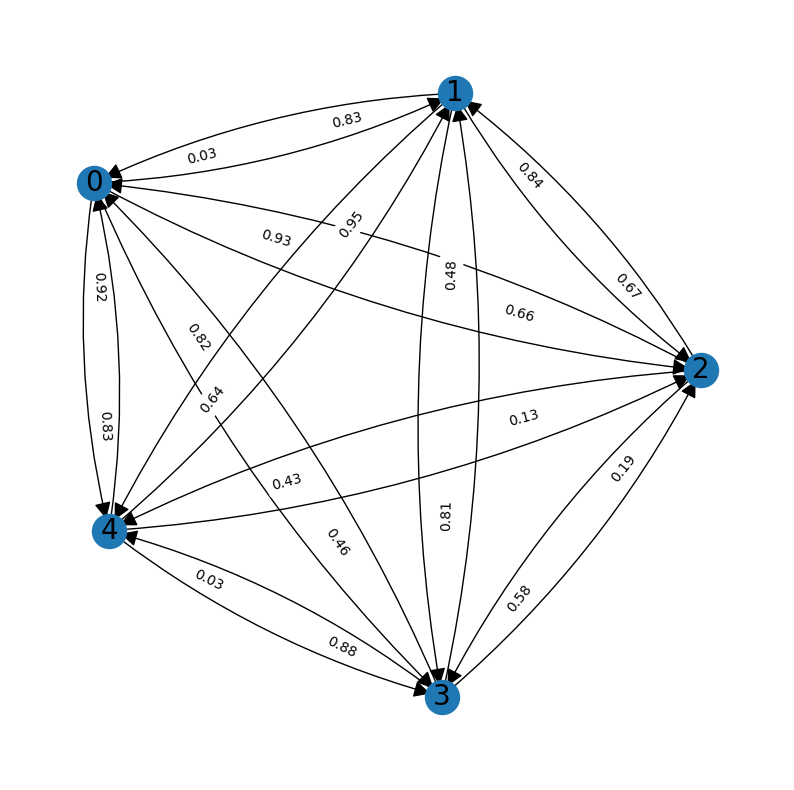

In [54]:
from Constants import *
import numpy as np
from Environment import Environment
from Network import Network
import random

def generate_click_probabilities(fully_connected : bool):

    adjacency_matrix = np.random.uniform(low=0.01, high = 1.000001, size = (NUM_OF_PRODUCTS, NUM_OF_PRODUCTS))
    adjacency_matrix[np.diag_indices(n = NUM_OF_PRODUCTS, ndim = 2)] = 0.0

    if not fully_connected:
        graph_mask = np.random.randint(low=0, high=2, size = adjacency_matrix.shape)
        adjacency_matrix = np.multiply(adjacency_matrix, graph_mask)
    
    # # maybe this normalization is not needed
    # for i in range(NUM_OF_PRODUCTS):
    #     col_sum = np.sum(adjacency_matrix[:, i])
    #     if col_sum != 0 :
    #         adjacency_matrix[:, i] = adjacency_matrix[:, i] / col_sum

    adjacency_matrix = np.round(adjacency_matrix, 2)
    return adjacency_matrix


def generate_observation_probabilities(click_probabilities):
    obs_prob = np.zeros(shape = (NUM_OF_PRODUCTS, NUM_OF_PRODUCTS))
    
    for product in range(NUM_OF_PRODUCTS):
        
        available_products = [i for i in range(0,NUM_OF_PRODUCTS) if i != product and click_probabilities[product][i]!=0.0]
        
        if len(available_products) >= 2:
            idxs = np.random.choice(a= available_products, size=max(2, len(available_products)), replace=False)
            obs_prob[product][idxs[0]] = 1
            obs_prob[product][idxs[1]] = LAMBDA
        elif len(available_products) == 1:
            obs_prob[product][available_products[0]] = 1
        else:
            continue

    return obs_prob

def generate_prices (product_range : int, users_range : int):
    '''
    users_range is greater than product_range since we want to increase a little the probability 
    that a user will buy a given product
    '''
    return np.round(np.random.random(size = NUM_OF_PRODUCTS) * product_range , 2), np.round(np.random.random(size = NUM_OF_PRODUCTS) * users_range , 2)

if __name__ == '__main__' :

    # click_probabilities == edge weights in our case
    click_probabilities = generate_click_probabilities(fully_connected=True)
    observations_probabilities = generate_observation_probabilities(click_probabilities=click_probabilities)
    
    concentration_params = [100] + [70] * NUM_OF_PRODUCTS
    alpha_users = np.random.dirichlet( alpha= concentration_params, size = 1)


    product_prices, users_reservation_prices = generate_prices(product_range=70, users_range=100)

    env = Environment(users_reservation_prices = users_reservation_prices,
                      product_prices = product_prices,
                      click_probabilities = click_probabilities,
                      observations_probabilities = observations_probabilities)

    Network.print_graph(G=env.network.G)

In [55]:
env.get_product_prices()

array([13.5 , 28.16, 45.8 , 34.92, 50.53])

In [56]:
from social_influence import *
nodes_activation_probabilities = montecarlo_sampling(env)

k: 100%|██████████| 4688/4688 [00:02<00:00, 1581.86it/s]


In [84]:
from Ecommerce import *

In [85]:
B_cap = 200

ecomm = Ecommerce(B_cap = B_cap)
ecomm.solve_optimization_problem(env = env, nodes_activation_probabilities = nodes_activation_probabilities)

[[0.1        0.25990609 0.41183849 0.54933838 0.6        0.6
  0.6        0.6        0.6        0.6        0.6       ]
 [0.1        0.40270973 0.65459972 0.75       0.75       0.75
  0.75       0.75       0.75       0.75       0.75      ]
 [0.1        0.47994896 0.76403677 0.85       0.85       0.85
  0.85       0.85       0.85       0.85       0.85      ]
 [0.1        0.28647169 0.46041127 0.57       0.57       0.57
  0.57       0.57       0.57       0.57       0.57      ]
 [0.1        0.34491866 0.56211716 0.73514895 0.86159416 0.93
  0.93       0.93       0.93       0.93       0.93      ]]


array([ 0., 40., 40., 60., 60.])

In [73]:
ecomm.budgets

array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.])